In [2]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import pickle

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 2
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
COST = 1./XDIM
EPSILON = 0.01
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

In [3]:
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# Utils

In [4]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [5]:
def load_spam_dataset():
    torch.manual_seed(0)
    np.random.seed(0)

    path = r"C:\Users\sagil\Desktop\nir project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_custom_data(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_custom_normal_data(N, pos_mean, pos_std, neg_mean, neg_std):
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.randn((pos_samples_num, XDIM))*pos_std + pos_mean
    negX = torch.randn((neg_samples_num, XDIM))*neg_std + neg_mean
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

# CCP classes

In [6]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        self.v = cp.Parameter(x_dim)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, self.v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope, v):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        v = v.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        self.v.value = v
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [7]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c_dpp_form"]
        
        self.x = cp.Variable(x_dim)
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.v = cp.Parameter(x_dim, value = np.random.randn(x_dim), nonneg=True)
        self.rv = cp.Parameter(x_dim, value = np.random.randn(x_dim)) # r times v
        self.r2v = cp.Parameter(x_dim, value = np.random.randn(x_dim)) # r squared times v
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.v, self.rv, self.r2v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.w, self.b, self.v, self.rv, self.r2v, self.f_der],
                                variables=[self.x])
        
    def optimize_X(self, X, w, b, v, F_DER):
        rv = X*v
        r2v = (X**2)*v
        return self.layer(w, b, v, rv, r2v, F_DER)[0]

# Gain & Cost functions

In [8]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, v):
    return COST*(((x-r)**2)@cp.abs(v))

def c_dpp_form(x, v, rv, r2v):
    return COST*cp.sum(cp.multiply(cp.square(x), v) - 2*cp.multiply(x, rv) + r2v)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "c_dpp_form": c_dpp_form, "score": score}

# Data generation

percent of positive samples: 43.0%


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


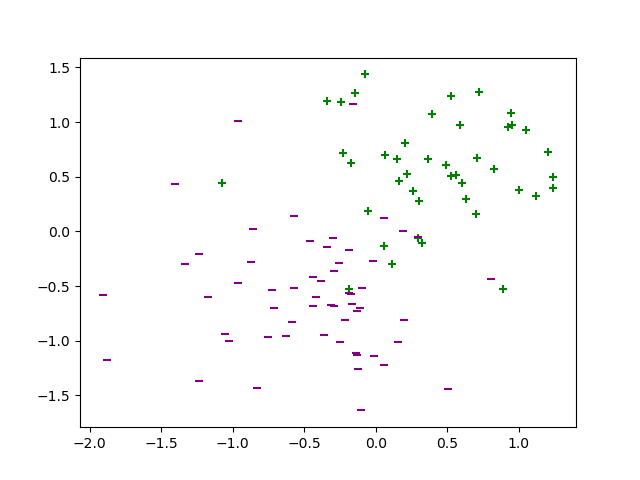

In [13]:
N = 200
X, Y = gen_custom_normal_data(N, torch.Tensor([0.5, 0.5]), torch.Tensor([0.5, 0.5]), torch.Tensor([-0.5, -0.5]), torch.Tensor([0.5, 0.5]))

assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.5)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.05)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
visualize_data(X, Y)
# visualize_data(Xval, Yval)
# visualize_data(Xtest, Ytest)

# Model

In [10]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, v_0, v_true, strategic=False, robust=False):
        torch.manual_seed(0)
        np.random.seed(0)
    
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.strategic = strategic
        self.robust = robust
        
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.v_true = v_true
        self.v_0 = v_0
        if self.robust:
            self.V = torch.stack([self.v_0 + 1.7, self.v_0 - 1.7])
        else:
            self.V = torch.stack([self.v_0])
        
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)
        
    def forward(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        
        if evaluation:
            if self.strategic:
                XT = self.ccp.optimize_X(X, self.w, self.b, slope, torch.abs(self.v_true))
                F_DER = self.get_f_ders(XT, slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, torch.abs(self.v_true), F_DER) # Xopt should equal to XT but we do it again for the gradients
                output = self.score(X_opt)
            else:
                output = self.score(X)
            return output
            
        outputs = torch.zeros((self.V.size()[0], X.size()[0]))
        for i, v in enumerate(self.V):
            if self.strategic:
                XT = self.ccp.optimize_X(X, self.w, self.b, slope, torch.abs(v))
                F_DER = self.get_f_ders(XT, slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, torch.abs(v), F_DER) # Xopt should equal to XT but we do it again for the gradients
                output = self.score(X_opt)
            else:
                output = self.score(X) 
            outputs[i] = output
        return outputs
    
    def optimize_X(self, X, evaluation=True):
        slope = self.eval_slope if evaluation else self.train_slope

        return self.ccp.optimize_X(X, self.w, self.b, slope, self.v_true)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        Y_pred = torch.sign(self.forward(X, evaluation=True))
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def loss(self, Y, Y_pred, evaluation=False):
        if evaluation:
            return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
        # return torch.mean(torch.max(torch.clamp(1 - Y_pred * Y, min=0), 0)[0])
        return torch.max(torch.mean(torch.clamp(1 - Y_pred * Y, min=0), 1))
    
    def save_model(self, X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xtest.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Ytest.csv')
        pd.DataFrame(self.V.numpy()).to_csv(path + '/V.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
            
        with open(path + '/model_data.pkl', 'wb') as output:
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir project/models/robustness/" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader: 
                try:
                    opt.zero_grad()
                    Ybatch_pred = self.forward(Xbatch)
                    l = self.loss(Ybatch, Ybatch_pred)
                    l.backward()
                    opt.step()

                    train_losses[-1].append(l.item())
                    if calc_train_errors:
                        with torch.no_grad():
                            e = self.evaluate(Xbatch, Ybatch)
                            train_errors[-1].append(1-e)
                    if verbose:
                        print("batch %03d / %03d | loss: %3.5f" %
                              (batch, len(train_loader), np.mean(train_losses[-1])))
                    batch += 1
                    if callback is not None:
                        callback()
                except:
                    print("failed")
                
            with torch.no_grad():
                try:
                    Yval_pred = self.forward(Xval, evaluation=True)
                    val_loss = self.loss(Yval, Yval_pred, evaluation=True).item()
                    val_losses.append(val_loss)
                    val_error = 1-self.evaluate(Xval, Yval)
                    val_errors.append(val_error)
                    if val_error < best_val_error:
                        consecutive_no_improvement = 0
                        best_val_error = val_error
                    else:
                        consecutive_no_improvement += 1
                        if consecutive_no_improvement >= 100:
                            break
                    if self.strategic:
                            info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                            time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                            self.save_model(X, Y, Xval, Yval, Xtest, Ytest, train_errors, val_errors, train_losses, val_losses, info, path, comment)
                            print("model saved!")
                except:
                    print("failed")
                    
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Train

In [14]:
EPOCHS = 6
BATCH_SIZE = 8

x_dim = XDIM
v_true = torch.Tensor([0.5, 0.5])
v_0 = torch.Tensor([2, 2])


# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=False, robust=False)

fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)


# strategic classification, flexible
print("---------- training strategically----------")
strategic_model_robust = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=True, robust=True)

fit_res_strategic_robust = strategic_model_robust.fit(X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                comment="robust")


# strategic classification, fixed
print("---------- training strategically----------")
strategic_model_fragile = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_0, v_true, strategic=True, robust=False)

fit_res_strategic_fragile = strategic_model_fragile.fit(X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                comment="fragile")


---------- training non-strategically----------
batch 001 / 013 | loss: 1.40114
batch 002 / 013 | loss: 1.24077
batch 003 / 013 | loss: 1.18936
batch 004 / 013 | loss: 1.17765
batch 005 / 013 | loss: 1.24220
batch 006 / 013 | loss: 1.21431
batch 007 / 013 | loss: 1.18740
batch 008 / 013 | loss: 1.14269
batch 009 / 013 | loss: 1.07383
batch 010 / 013 | loss: 1.06376
batch 011 / 013 | loss: 1.00452
batch 012 / 013 | loss: 0.98869
batch 013 / 013 | loss: 0.97190
----- epoch 001 / 006 | time: 000 sec | loss: 0.37564 | err: 0.08421
batch 001 / 013 | loss: 0.29747
batch 002 / 013 | loss: 0.33304
batch 003 / 013 | loss: 0.36360
batch 004 / 013 | loss: 0.35424
batch 005 / 013 | loss: 0.33677
batch 006 / 013 | loss: 0.33347
batch 007 / 013 | loss: 0.31259
batch 008 / 013 | loss: 0.30372
batch 009 / 013 | loss: 0.28991
batch 010 / 013 | loss: 0.27918
batch 011 / 013 | loss: 0.27619
batch 012 / 013 | loss: 0.25703
batch 013 / 013 | loss: 0.25891
----- epoch 002 / 006 | time: 000 sec | loss: 0.235

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l


batch 009 / 013 | loss: 0.13287
batch 010 / 013 | loss: 0.21272
batch 011 / 013 | loss: 0.22436
batch 012 / 013 | loss: 0.20566
batch 013 / 013 | loss: 0.21170
----- epoch 006 / 006 | time: 000 sec | loss: 0.17262 | err: 0.05263
training time: 0.160691499710083 seconds
---------- training strategically----------


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 013 | loss: 1.38779
batch 002 / 013 | loss: 1.21157
batch 003 / 013 | loss: 1.15779
batch 004 / 013 | loss: 1.15491
batch 005 / 013 | loss: 1.25063
batch 006 / 013 | loss: 1.23962
batch 007 / 013 | loss: 1.22930
batch 008 / 013 | loss: 1.18822
batch 009 / 013 | loss: 1.12517
batch 010 / 013 | loss: 1.14542
batch 011 / 013 | loss: 1.12444
batch 012 / 013 | loss: 1.15176
batch 013 / 013 | loss: 1.13319
model saved!
----- epoch 001 / 006 | time: 048 sec | loss: 0.63458 | err: 0.40000
batch 001 / 013 | loss: 0.90705
batch 002 / 013 | loss: 0.74968
batch 003 / 013 | loss: 0.71389
batch 004 / 013 | loss: 0.67270
batch 005 / 013 | loss: 0.75239
batch 006 / 013 | loss: 0.76686
batch 007 / 013 | loss: 0.82824
batch 008 / 013 | loss: 0.81606
batch 009 / 013 | loss: 0.83269
batch 010 / 013 | loss: 0.84984
batch 011 / 013 | loss: 0.84050
batch 012 / 013 | loss: 0.82369
batch 013 / 013 | loss: 0.82126
model saved!
----- epoch 002 / 006 | time: 048 sec | loss: 0.74166 | err: 0.23158
batc

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 013 | loss: 1.37496
batch 002 / 013 | loss: 1.19674
batch 003 / 013 | loss: 1.14483
batch 004 / 013 | loss: 1.14642
batch 005 / 013 | loss: 1.23783
batch 006 / 013 | loss: 1.22148
batch 007 / 013 | loss: 1.20598
batch 008 / 013 | loss: 1.16089
batch 009 / 013 | loss: 1.09376
batch 010 / 013 | loss: 1.09646
batch 011 / 013 | loss: 1.04995
batch 012 / 013 | loss: 1.05318
batch 013 / 013 | loss: 1.03634
model saved!
----- epoch 001 / 006 | time: 034 sec | loss: 0.76432 | err: 0.43158
batch 001 / 013 | loss: 0.55011
batch 002 / 013 | loss: 0.51950
batch 003 / 013 | loss: 0.48478
batch 004 / 013 | loss: 0.42594
batch 005 / 013 | loss: 0.44120
batch 006 / 013 | loss: 0.43975
batch 007 / 013 | loss: 0.44096
batch 008 / 013 | loss: 0.41468
batch 009 / 013 | loss: 0.41848
batch 010 / 013 | loss: 0.41724
batch 011 / 013 | loss: 0.40681
batch 012 / 013 | loss: 0.38554
batch 013 / 013 | loss: 0.37049
model saved!
----- epoch 002 / 006 | time: 047 sec | loss: 0.71052 | err: 0.35789
batc

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


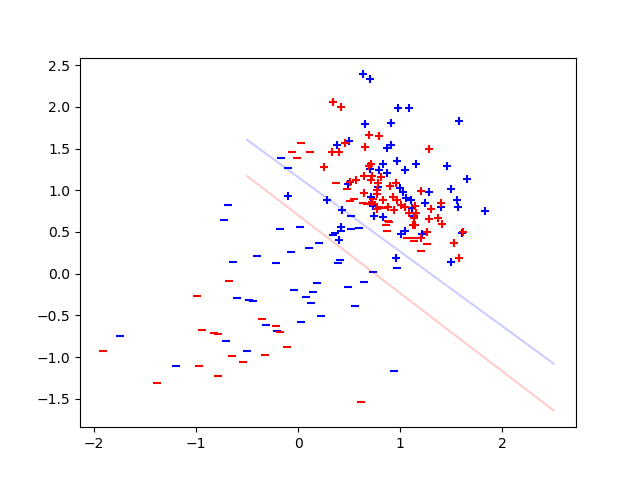

In [15]:
Xval_opt_robust = strategic_model_robust.optimize_X(Xval, True)
Xval_opt_fragile = strategic_model_fragile.optimize_X(Xval, True)

visualize_strategic_data(Xval_opt_robust, Xval_opt_fragile, Yval, strategic_model_robust.w, strategic_model_robust.b, strategic_model_fragile.w, strategic_model_fragile.b)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


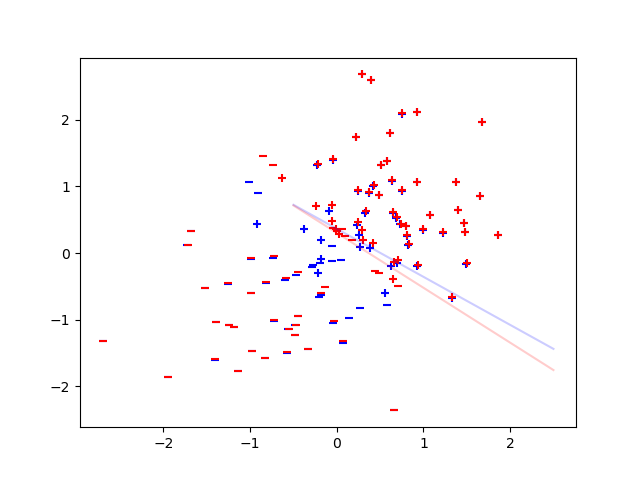

In [19]:
visualize_strategic_data(Xval, Xval_opt_fragile, Yval, strategic_model_robust.w, strategic_model_robust.b, strategic_model_fragile.w, strategic_model_fragile.b)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


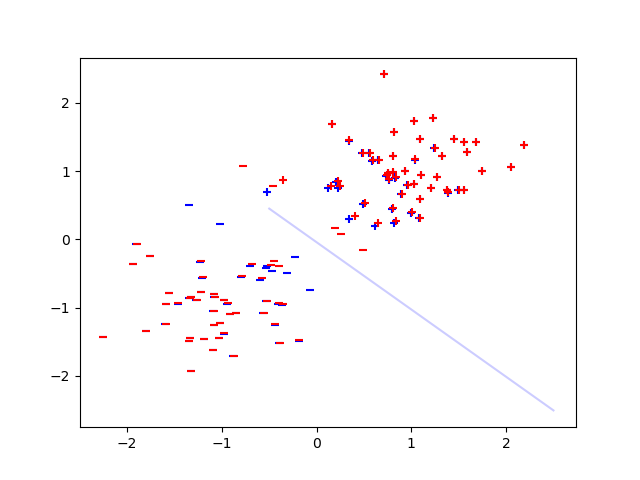

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


<IPython.core.display.Javascript object>


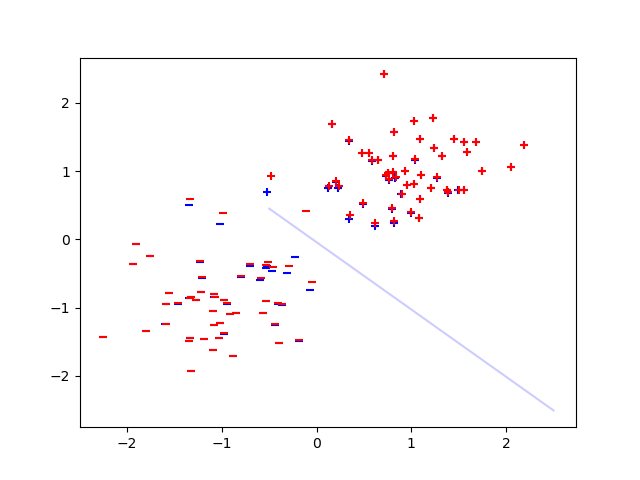

<IPython.core.display.Javascript object>


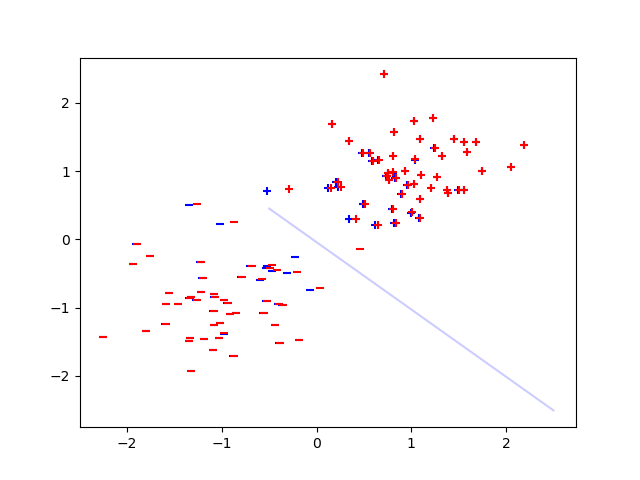

<IPython.core.display.Javascript object>


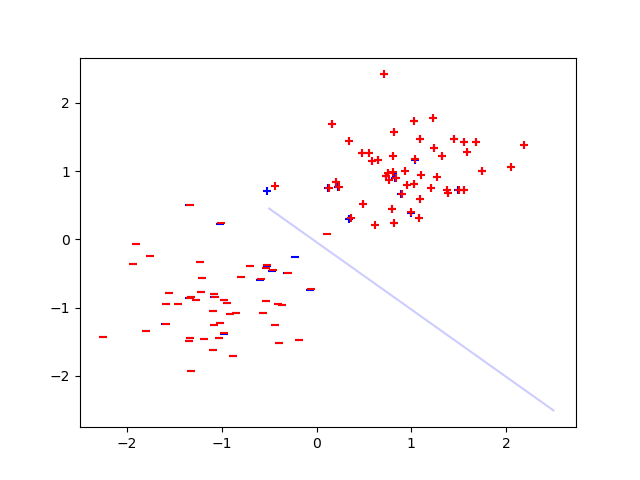

In [11]:
non_strategic_model.v_true = torch.Tensor([0.5, 0.5])
Xval_opt = non_strategic_model.optimize_X(Xval, True)
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, torch.zeros(XDIM), torch.zeros(1))

non_strategic_model.v_true = torch.Tensor([3, 0.5])
Xval_opt = non_strategic_model.optimize_X(Xval, True)
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, torch.zeros(XDIM), torch.zeros(1))

non_strategic_model.v_true = torch.Tensor([0.5, 3])
Xval_opt = non_strategic_model.optimize_X(Xval, True)
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, torch.zeros(XDIM), torch.zeros(1))

non_strategic_model.v_true = torch.Tensor([3, 3])
Xval_opt = non_strategic_model.optimize_X(Xval, True)
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, torch.zeros(XDIM), torch.zeros(1))

# Test results

In [12]:
strategic_model_flex = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_orig, strategic=True, flexible=True, lamb=LAMBDA)
strategic_model_flex.load_model(r"C:\Users\sagil\Desktop\nir project\models\robustness\23-01-2021_21-38-09_____flexible\model.pt")

strategic_model_fixed = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, v_orig[2:3], strategic=True, flexible=False)
strategic_model_fixed.load_model(r"C:\Users\sagil\Desktop\nir project\models\robustness\23-01-2021_21-57-40_____fixed\model.pt")

print(strategic_model_flex.evaluate(Xval, Yval))
print(strategic_model_fixed.evaluate(Xval, Yval))

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

0.88
0.88


In [13]:
for i in range(5):
    strategic_model_flex.V = v_orig[i:i+1]
    strategic_model_fixed.V = v_orig[i:i+1]
    print(strategic_model_flex.evaluate(Xval, Yval))
    print(strategic_model_fixed.evaluate(Xval, Yval))

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.88
0.88
0.86
0.86
0.88
0.88
0.0
0.0
0.0
0.0


In [15]:
print("non strategic model + non strategic data: ", non_strategic_model.evaluate(Xval, Yval))
print("non strategic model + strategic data: ", non_strategic_model.evaluate(Xval_opt, Yval))
print("flexible strategic model + strategic data: ", strategic_model_flex.evaluate(Xval, Yval))
print("fixed strategic model + strategic data: ", strategic_model_not_flex.evaluate(Xval, Yval))

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


non strategic model + non strategic data:  0.992
non strategic model + strategic data:  0.544
flexible strategic model + strategic data:  0.984
fixed strategic model + strategic data:  0.848


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


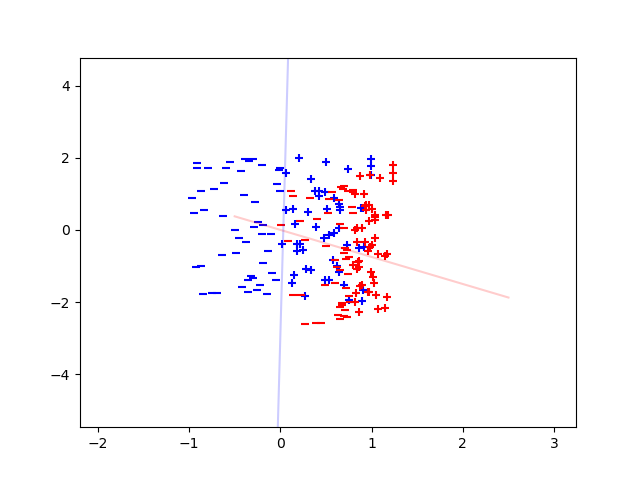

In [19]:
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, non_strategic_model.v, torch.zeros(1))

Parameter containing:
tensor([0.0316, 0.0060], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


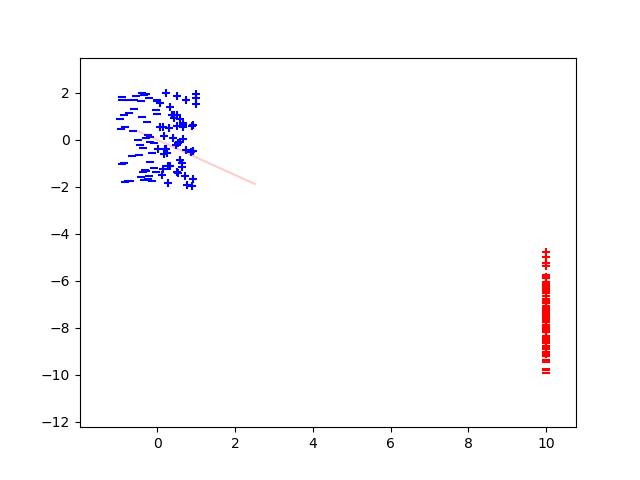

In [23]:
print(strategic_model_not_flex.w)
visualize_strategic_data(Xval, Xval_opt_not_flex, Yval, strategic_model_not_flex.w, strategic_model_not_flex.b, strategic_model_not_flex.v, torch.zeros(1))

Parameter containing:
tensor([ 1.4378, -0.2290], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


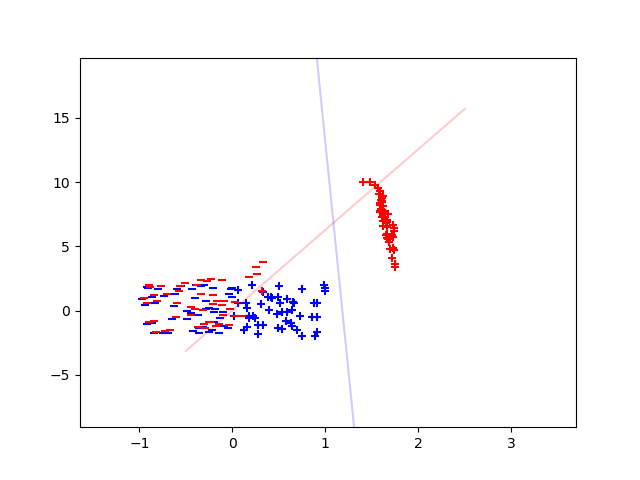

In [22]:
print(strategic_model_flex.v)
visualize_strategic_data(Xval, Xval_opt_flex, Yval, strategic_model_flex.w, strategic_model_flex.b, strategic_model_flex.v, torch.zeros(1))